This notebook is a starting point for using the [Whoosh](https://whoosh.readthedocs.io/) search engine to extract snippets of text for text analysis. First off, let's get our import statements out of the way.

In [1]:
# some standard libraries
import os,sys,re

# whoosh support
from whoosh.index import create_in
from whoosh.fields import Schema, TEXT, ID
from whoosh.qparser import QueryParser
from whoosh import scoring
from whoosh.index import open_dir
import whoosh.highlight as highlight

# support for text analysis
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Leddemo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

We will also collect our classes and functions in one place.

In [2]:
class MinimalFormatter(highlight.Formatter):

    def format_token(self, text, token, replace=False):
        tokentext = highlight.get_text(text, token, replace)

        # this could be elaborate as shown 
        # return "[%s]" % tokentext

        # but just return the token here
        return tokentext

def createSearchableData(root,indexdir):   
 
    # Note that we need content to be stored for highlighting to work
    schema = Schema(title=TEXT(stored=True),path=ID(stored=True),
              content=TEXT(stored=True))
    if not os.path.exists(indexdir):
        os.mkdir(indexdir)
 
    # Creating an index writer to add documents
    ix = create_in(indexdir,schema)
    writer = ix.writer()
 
    # The text should probably be pulled from a remote repository
    # but assume it is local for now
    filepaths = [os.path.join(root,i) for i in os.listdir(root)]
    for path in filepaths:
        fp = open(path,'r', encoding='utf8')
        text = fp.read()
        writer.add_document(title=path.split(os.sep)[1], path=path,
          content=text)
        fp.close()
    writer.commit()

An index only has to be created once (if the data has not changed). This next cell can be skipped if the index is already there.

In [3]:
createSearchableData("1904_01","npindex") # we use January, 1904 as a sample set

Now use the index for getting highlights. The highlights will be our snippets. Whoosh has the plumbing for something far more elaborate but keep it simple for now.

In [4]:
# the index directory contains the index
ix = open_dir("npindex")
 
qp = QueryParser("content", schema=ix.schema)
q = qp.parse(u"wom?n") # note the wildcard, this will give us "woman" and "women"

with ix.searcher() as s:
    results = s.search(q)

    # using the class above
    minf = MinimalFormatter()
    results.formatter = minf

    snippets = []
    for hit in results:
        # clean up the spaces in the result
        snippet = " ".join(hit.highlights("content").split())
        snippets.append(snippet)

At this point, the snippets/highlights are collected. Now we handover the results to the powerful [pandas](https://pandas.pydata.org/) library.

In [7]:
df = pd.DataFrame(snippets,columns=['Snippet'])
df["row_id"] = df.index + 1

#remove all non-alphabet characters
df['Snippet'] = df['Snippet'].str.replace("[^a-zA-Z#]", " ", regex=True)
#covert to lower-case
df['Snippet'] = df['Snippet'].str.casefold()

The following is based on the redgate tutorial at [Sentiment Analysis with Python](https://www.red-gate.com/simple-talk/development/data-science-development/sentiment-analysis-python/). This is for illustrative purposes, [VADER](https://github.com/cjhutto/vaderSentiment) may not be the right tool for historical text.

In [14]:
sid = SentimentIntensityAnalyzer()
tmp = [['99999999999','NA999NA',0]] # dummy row (in case there is nothing)
for index, row in df.iterrows():
    scores = sid.polarity_scores(row[0])   
    for key, value in scores.items():
        tmp.append([row[1],key,value])

# this is a slight variation, the original append method is being depreciated
t_df=pd.DataFrame(tmp,columns=['row_id','sentiment_type','sentiment_score'])

# remove dummy row with row_id = 99999999999
t_df_cleaned = t_df[t_df.row_id != '99999999999']
# remove duplicates if any exist
t_df_cleaned = t_df_cleaned.drop_duplicates()
# only keep rows where sentiment_type = compound
t_df_cleaned = t_df[t_df.sentiment_type == 'compound']
print(t_df_cleaned.head(5)) # check first few results

   row_id sentiment_type  sentiment_score
4       1       compound           0.6369
8       2       compound           0.0516
12      3       compound           0.2023
16      4       compound           0.0772
20      5       compound           0.8860


See above link for explaination.

In [15]:
#merge dataframes
df_output = pd.merge(df, t_df_cleaned, on='row_id', how='inner')
print(df_output.head(2)) # check a few snippets

                                             Snippet row_id sentiment_type  \
0  girl or middle agep woman for general house   ...      1       compound   
1  stavens   a woman  tender  foot  mrs  thompson...      2       compound   

   sentiment_score  
0           0.6369  
1           0.0516  


Get some details on the scoring.

In [12]:
df_output[["sentiment_score"]].describe()

,sentiment_score
count,10.000000
mean,0.162320
std,0.377478
min,-0.296000
25%,0.000000
50%,0.064400
75%,0.321475
max,0.886000


The graphing is a little misdirected in my sample, it would make more sense to compare time periods around an event, for example.

<AxesSubplot:title={'center':'Sentiment Score'}, xlabel='Snippet', ylabel='Mean Sentiment Score'>

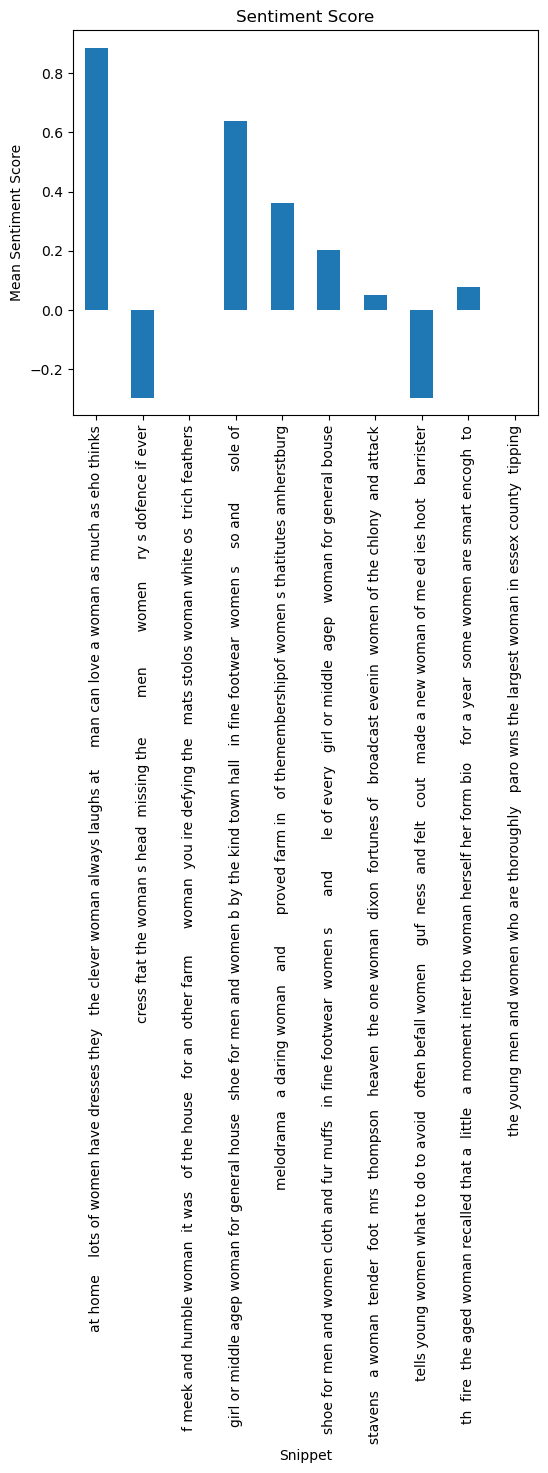

In [13]:
# generate mean of sentiment_score by snippet
dfg = df_output.groupby(['Snippet'])['sentiment_score'].mean()
# create a bar plot

dfg.plot(kind='bar', title='Sentiment Score', ylabel='Mean Sentiment Score',
         xlabel='Snippet', figsize=(6, 5))

And that's it!